<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Used_Car_Quality_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Car Quality Detection by XBboost and Random Forests**

Machine learning is the science of getting computers to act without being explicitly programmed. In the past decade, machine learning has given us self-driving cars, practical speech recognition, effective web search, and a vastly improved understanding of the human genome. Machine learning is so pervasive today that you probably use it dozens of times a day without knowing it. In this notebook I implement two of the most known machine learning algorthim to predict the quality of a car.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Expainatory Data Analysis](#3)
  4. [Feature Engineering](#4)
  4. [Data Cleaning and Pipelines Implementation](#4)
  5. [Implemneting Random Forest](#5)
  6. [Implemneting XBboost Forest](#6)
  7. [Hyperparamterization](#7)
  8. [Testing the models on sample dataset](#8)
  9. [Summary](#9)
  10. [Future Work](#10)
  11. [References](#11)

# <font color="darkslateblue" size=+2.0><b>1: AboutDataset</b></font> <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this competition is to predict if the car purchased at the Auction is a Kick (bad buy).

- The challenge of this competition is to predict if the car purchased at the Auction is a good / bad buy.
- All the variables in the data set are defined in the file Carvana_Data_Dictionary.txt 
- The data contains missing values 
- The dependent variable (IsBadBuy) is binary (C2)
- There are 32 Independent variables (C3-C34)
- The data set is split to 60% training and 40% testing.

# <font color="black" size=+2.0><b>2: Loading the dataset Preprocessing</b></font> <a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Downloading all the required python packages to get started, also imported all the required libraries

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

In [2]:
#importing dataset
import os
import opendatasets as od
import pandas as pd
import numpy as np

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import time

#for visualization
import seaborn as sns
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

To download the dataset from Kaggle, I use the library **od**.

To connect to kaggle enter user Kaggle username name and API key. 

Please read though this article to understand the process of getting your API key from kaggle.

https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [3]:
od.download('https://www.kaggle.com/c/DontGetKicked/data?select=test.csv')

Skipping, found downloaded files in "./DontGetKicked" (use force=True to force download)


Below are the list of files downloaded. You can access all the downloaded filename using os.listdir(<'downloaded folder name'>)

In [4]:
os.listdir('DontGetKicked')

['training.zip',
 'test.zip',
 'example_entry.csv',
 'test.csv',
 'Carvana_Data_Dictionary.txt',
 'training.csv']

I use pandas to read the train and test data sets. Here I access few records of training dataset

In [5]:
train=pd.read_csv('/content/DontGetKicked/training.csv') 
test= pd.read_csv('/content/DontGetKicked/test.csv')
train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


# <font color="white" size=+2.0><b>3: Expainatory Data Analysis</b></font> <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# <font color="white" size=+2.0><b>4: Feature Engineering</b></font> <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

Before performing the feature engineering, let us first check the data quality and identify null values.

In [7]:
print(train.isnull().sum())

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

In [8]:
print(test.isnull().sum())

RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1550
SubModel                                 5
Color                                    4
Transmission                             3
WheelTypeID                           2188
WheelType                             2188
VehOdo                                   0
Nationality                              7
Size                                     7
TopThreeAmericanName                     7
MMRAcquisitionAuctionAveragePrice       10
MMRAcquisitionAuctionCleanPrice         10
MMRAcquisitionRetailAveragePrice        10
MMRAcquisitonRetailCleanPrice           10
MMRCurrentAuctionAveragePrice          143
MMRCurrentAuctionCleanPrice            143
MMRCurrentR

**Checking Duplicates**

In [9]:
train[train.duplicated()]

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


In [10]:
test[test.duplicated()]

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


As we see above, many column contains null values. It is important for us to understand the relevant columns that would help model to better generalize.
Hence following columns seems not relevant that are requied to be passed to the model
- PurchDate (Date might not be relevant by Year would be)
- WheelTypeID
- Model
- Trim 
- SubModel
- Make
- VNZIP1
- VNST
- Color

Here I create few addtional column using the existing column to drive some addtional features from the datasets.

The additional features help the model in better training, aslo ensuring the model to be more generalized.

In [11]:
def split_date(df):
  df['PurchDate'] = pd.to_datetime(df['PurchDate'])
  df['Year'] = df.PurchDate.dt.year

In [12]:
def MeanOnFeatures(df):
  df['mean_MMRCurrentAuctionAveragePrice_Make']=train.groupby(['Make'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Model']=train.groupby(['Model'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Trim']=train.groupby(['Trim'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_SubModel']=train.groupby(['SubModel'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Color']=train.groupby(['Color'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Transmission']=train.groupby(['Transmission'])['MMRCurrentAuctionAveragePrice'].transform('mean')

In [13]:
print(train.shape, test.shape)

(72983, 34) (48707, 33)


In [14]:
split_date(train)
split_date(test)

print(train.shape, test.shape)

MeanOnFeatures(train)
MeanOnFeatures(test)

(72983, 35) (48707, 34)


In [15]:
print(train.shape, test.shape)

(72983, 41) (48707, 40)


In [16]:
not_relevant_coulmns = ["RefId", "PurchDate", "WheelTypeID", "Model", "Trim", "SubModel", "VNZIP1", "VNST", "Make", "Color"]

def remove_features(df):
  df.drop(not_relevant_coulmns, axis=1, inplace=True)

remove_features(train)
remove_features(test)

In [17]:
print(train.shape, test.shape)

(72983, 31) (48707, 30)


**Handling NaN**

In [18]:
train.isnull().sum()

IsBadBuy                                               0
Auction                                                0
VehYear                                                0
VehicleAge                                             0
Transmission                                           9
WheelType                                           3174
VehOdo                                                 0
Nationality                                            5
Size                                                   5
TopThreeAmericanName                                   5
MMRAcquisitionAuctionAveragePrice                     18
MMRAcquisitionAuctionCleanPrice                       18
MMRAcquisitionRetailAveragePrice                      18
MMRAcquisitonRetailCleanPrice                         18
MMRCurrentAuctionAveragePrice                        315
MMRCurrentAuctionCleanPrice                          315
MMRCurrentRetailAveragePrice                         315
MMRCurrentRetailCleanPrice     

I observed one particular scenario where the categrical values are varying becuase of the case sensitive issue. 

In [19]:
train.Transmission.value_counts()

AUTO      70398
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [20]:
# This should reslove this difference
train["Transmission"].replace("Manual", "MANUAL", inplace=True)

The target values seems to be highly imbalance. This is not good for our machine learning model

In [21]:
train.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

1    64007
0    64007
Name: IsBadBuy, dtype: int64


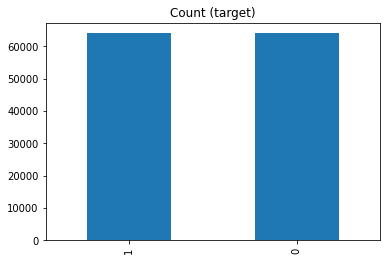

In [22]:
count_class_0, count_class_1 = train.IsBadBuy.value_counts()

df_class_0 = train[train['IsBadBuy'] == 0]
df_class_1 = train[train['IsBadBuy'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.IsBadBuy.value_counts())

df_test_over.IsBadBuy.value_counts().plot(kind='bar', title='Count (target)');

# <font color="white" size=+2.0><b>5: Data Cleaning, Spliting and Pipelines Implementation</b></font> <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

We perform the following tasks under this section
- Segregating the features and target.
- Identifying the numberical and categorical columns.
- Spliting the dataset between train and testing. 
- For numberical columns
  - Used KNN Imputer to fill the missing values.
  - MinMaxScaler() to normalize the numberical values.
- For categorical columns
  - Used Simple Imputer to fill up the missing values.
  - OneHotEncoder to all the catogorical columns.
- Finally all the above steps are put inside a **pipelines**

In [23]:
#create X and y datasets for splitting 
X = df_test_over.drop(['IsBadBuy'], axis=1)
y = df_test_over['IsBadBuy']

In [25]:
all_features = X.columns
all_features = all_features.tolist()

In [26]:
numerical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind in ['i','f']]
categorical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind not in ['i','f']]

In [27]:
#import train_test_split library
from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [28]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [29]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 50)
                                 )

# <font color="white" size=+2.0><b>6: Implemneting Random Forest</b></font> <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [30]:
RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))

In [31]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

1.0

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation/test set too.

We can make predictions and compute accuracy in one step using model.score

In [32]:
RF_Model.score(X_test, y_test)

0.9841947663064705

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. One possible reason might be because we to reslove oversampling we ended up inducing some overlaps between testing and training set hence we are observing a very high accuracy. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

I can now think of two possible solutions
1. hyperparamterization to over come the overfitting. I will cover this in next section.
2. Instead of spliting the data in train and testing set. Let us train on the entire set in one go this valiation strategy is called as K-fold cross validation.

I will implement point 2 using XGboost.

# <font color="white" size=+2.0><b>7: Hyperparamterization and Parameter Tuning  - Random Forest</b></font> <a name="7"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

As we saw in the previous section, our random tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as regularlization.


By varying the following fields, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [34]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [35]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1')

In [36]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 19.9 s, sys: 419 ms, total: 20.4 s
Wall time: 3min 10s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['VehYear',
                                                                            

In [37]:
rf_RandomGrid.score(X_train, y_train)

0.7047100183930526

In [38]:
rf_RandomGrid.score(X_test, y_test)

0.6958153193572071

I now pick the best parameters which would help to me to achive better accuray from the avalaible list of parameters

In [39]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    

Accuracy

In [40]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.705
Test : 0.696


It is observed that although the accuray has dropped significantly but the deviation between the training and test sets is minimal. Hence our model is fairly generalized.

# <font color="white" size=+2.0><b>8: Implementing XBboost Forest</b></font> <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [41]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    #SimpleImputer(strategy = 'median'),
    KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),

)

preprocessor_best = make_pipeline(preprocessor,
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 50)
                                 )


In [42]:
from xgboost import XGBClassifier
import xgboost as xgb
# model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4, use_label_encoder=False)


XG_model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))

In [43]:
%%time

# XG_model.fit(X_train, y_train)
XG_model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 6s, sys: 3.52 s, total: 2min 10s
Wall time: 1min 32s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    'MMRAcquis

In [45]:
# XG_model.score(X_train, y_train)
XG_model.score(X, y)

0.8370490727576672

**K Fold Cross Validation**

In [47]:
from sklearn.model_selection import KFold

In [49]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = make_pipeline(preprocessor_best, XGBClassifier(random_state=42, n_jobs=-1, **params))
    # model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_accuracy = model.score(X_train, train_targets)
    val_accuracy = model.score(X_val, val_targets)
    return model, train_accuracy, val_accuracy

In [48]:
kfold = KFold(n_splits=5)

In [51]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:23:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7321576783743934, Validation Accuracy: 0.3810881537319845


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7148939078809894, Validation Accuracy: 0.39284458852478227


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:26:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7126871136889592, Validation Accuracy: 0.48498222864508067


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:28:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7391100565368954, Validation Accuracy: 0.43030113658555635


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:29:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7381556848806781, Validation Accuracy: 0.4356690883524725


Train Accuracy: 0.7321576783743934, Validation Accuracy: 0.3810881537319845

Train Accuracy: 0.7148939078809894, Validation Accuracy: 0.39284458852478227

Train Accuracy: 0.7126871136889592, Validation Accuracy: 0.48498222864508067

Train Accuracy: 0.7391100565368954, Validation Accuracy: 0.43030113658555635

Train Accuracy: 0.7381556848806781, Validation Accuracy: 0.4356690883524725


Let's also define a function to average predictions from the 5 different models.

In [52]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [53]:
preds = predict_avg(models, X)

In [54]:
preds

array([0. , 0.4, 0.2, ..., 0.2, 0.4, 0.2])

We can now use predict_avg to make predictions for the test set.

# <font color="white" size=+2.0><b>9: Hyperparamterization and Parameter Tuning  - XGboost</b></font> <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [55]:
param_grid = {
# Number of trees in random forest
'xgbclassifier__n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)],
# Number of features to consider at every split
'xgbclassifier__learning_rate' : [0.1, 0.2, 0.3],
#Maximum number of levels in tree
'xgbclassifier__max_depth' : [2, 4, 6, 8]

}

print(param_grid)

{'xgbclassifier__n_estimators': [100, 109, 118, 127, 136, 145, 154, 163, 172, 181, 190, 200, 209, 218, 227, 236, 245, 254, 263, 272, 281, 290, 300, 309, 318, 327, 336, 345, 354, 363, 372, 381, 390, 400, 409, 418, 427, 436, 445, 454, 463, 472, 481, 490, 500, 509, 518, 527, 536, 545, 554, 563, 572, 581, 590, 600, 609, 618, 627, 636, 645, 654, 663, 672, 681, 690, 700, 709, 718, 727, 736, 745, 754, 763, 772, 781, 790, 800, 809, 818, 827, 836, 845, 854, 863, 872, 881, 890, 900, 909, 918, 927, 936, 945, 954, 963, 972, 981, 990, 1000], 'xgbclassifier__learning_rate': [0.1, 0.2, 0.3], 'xgbclassifier__max_depth': [2, 4, 6, 8]}


In [56]:
XG_RandomGrid = RandomizedSearchCV(estimator = XG_model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1')

In [ ]:
# XG_RandomGrid.fit(X_train, y_train)
XG_RandomGrid.fit(X_train, train_targets)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
# XG_model.best_estimator_

XG_RandomGrid.best_estimator_

In [ ]:
# print(f'Train : {XG_RandomGrid.score(X_train, y_train):.3f}')
print(f'Train : {XG_RandomGrid.score(X_train, train_targets):.3f}')

In [ ]:
# print(f'Test : {XG_RandomGrid.score(X_test, y_test):.3f}')
print(f'Test : {XG_RandomGrid.score(X_val, val_targets):.3f}')


# <font color="white" size=+2.0><b>8: Testing the models on sample dataset</b></font> <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [ ]:
example_entry = pd.read_csv('/content/DontGetKicked/example_entry.csv')
example_entry

In [ ]:
preds = XG_RandomGrid.predict(test)

In [ ]:
output = pd.DataFrame({'Refid': test.Refid, 'IsBadBuy': preds})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

# <font color="white" size=+2.0><b>9: Summary</b></font> <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# <font color="white" size=+2.0><b>10: Future Work</b></font> <a name="10"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

# <font color="white" size=+2.0><b>11: References</b></font> <a name="11"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [ ]:
model.feature_importances_

In [ ]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');